<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW4_woodenML_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

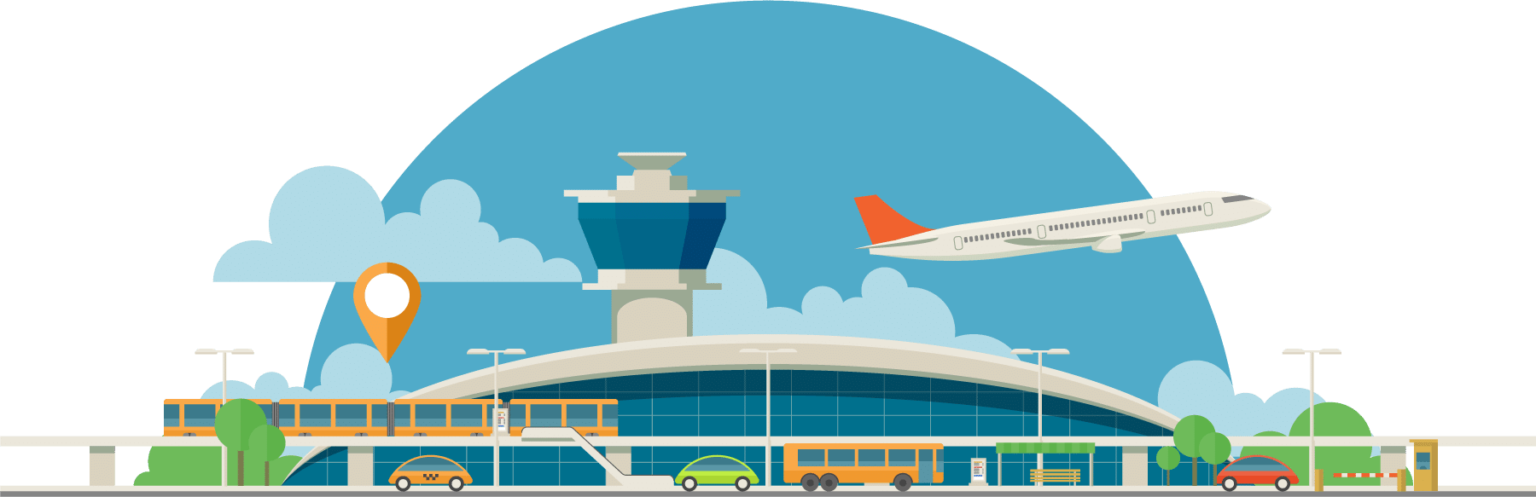

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

# !pip install catboost
# !pip install mlxtend --upgrade
# !pip install optuna
# !pip install lime
# !pip install shap
# !pip install missingno
# !pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

/Users/pavel/Documents/HSE-AI/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
# !mkdir -p ~/.postgresql && \
# wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
#     --output-document ~/.postgresql/root.crt && \
# chmod 0600 ~/.postgresql/root.crt

### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Схема БД**

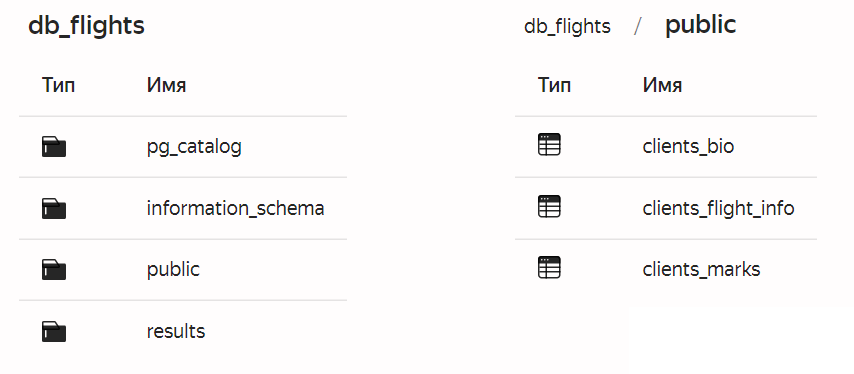



In [4]:
# Ваш код здесь
import json

with open('db_config.json', 'r', encoding='utf-8') as file:
    db_config = json.load(file)

join_query = """
SELECT 
    cm.id,
    cm."Inflight wifi service",
    cm."Departure/Arrival time convenient",
    cm."Ease of Online booking",
    cm."Gate location",
    cm."Food and drink",
    cm."Online boarding",
    cm."Seat comfort",
    cm."Inflight entertainment",
    cm."On-board service",
    cm."Leg room service",
    cm."Baggage handling",
    cm."Checkin service",
    cm."Inflight service",
    cm.cleanliness,
    cm.satisfaction,
    cfi."Customer Type",
    cfi."Type of Travel",
    cfi.class,
    cfi."Flight Distance",
    cfi."Departure Delay in Minutes",
    cfi."Arrival Delay in Minutes",
    cb.gender,
    cb.age
FROM clients_marks cm 
INNER JOIN clients_flight_info cfi ON cm.id = cfi.id
INNER JOIN clients_bio cb ON cfi.id = cb.id
"""

try:
    conn = psycopg2.connect(
        host=db_config["host"],
        port=db_config["port"],
        sslmode=db_config["sslmode"],
        dbname=db_config["dbname"],
        user=db_config["user"],
        password=db_config["password"],
        target_session_attrs=db_config["target_session_attrs"]
    )
    
    query = join_query
    df = pd.read_sql_query(query, conn)

except Exception as e:
    print("Ошибка при подключении к базе данных:", e)

finally:
    if conn:
        conn.close()

/var/folders/j7/bpk2y95s0x12x19c3ryr4v7r0000gn/T/ipykernel_65658/883523194.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
df.set_index('id', inplace=True)

In [6]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [7]:
columns_to_convert = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'cleanliness',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'age'
]

df[columns_to_convert] = df[columns_to_convert].astype(float)

In [8]:
df.isna().sum()

Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
gender                                 0
age                                  315
dtype: int64

В датафрейме имеются пропуски во многих колонках, однако их общее количество невелико относительно обзего размера датафрейма (129 505 наблюдений)

In [9]:
df.describe()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age
count,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000,129455.000000,129442.000000,129042.000000,129234.000000
mean,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780,1322.922158,15.809026,16.656499,40.116951
std,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466,4517.816532,93.276882,109.285072,20.376129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,414.000000,0.000000,0.000000,27.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,846.000000,0.000000,0.000000,40.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1744.000000,12.000000,13.000000,51.000000
max,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000,379620.000000,22227.000000,14006.000000,621.000000


Анализируя разницу между max и 75% перцентилем можно сделать вывод о наличии выбросов во всех количественных столбцах.

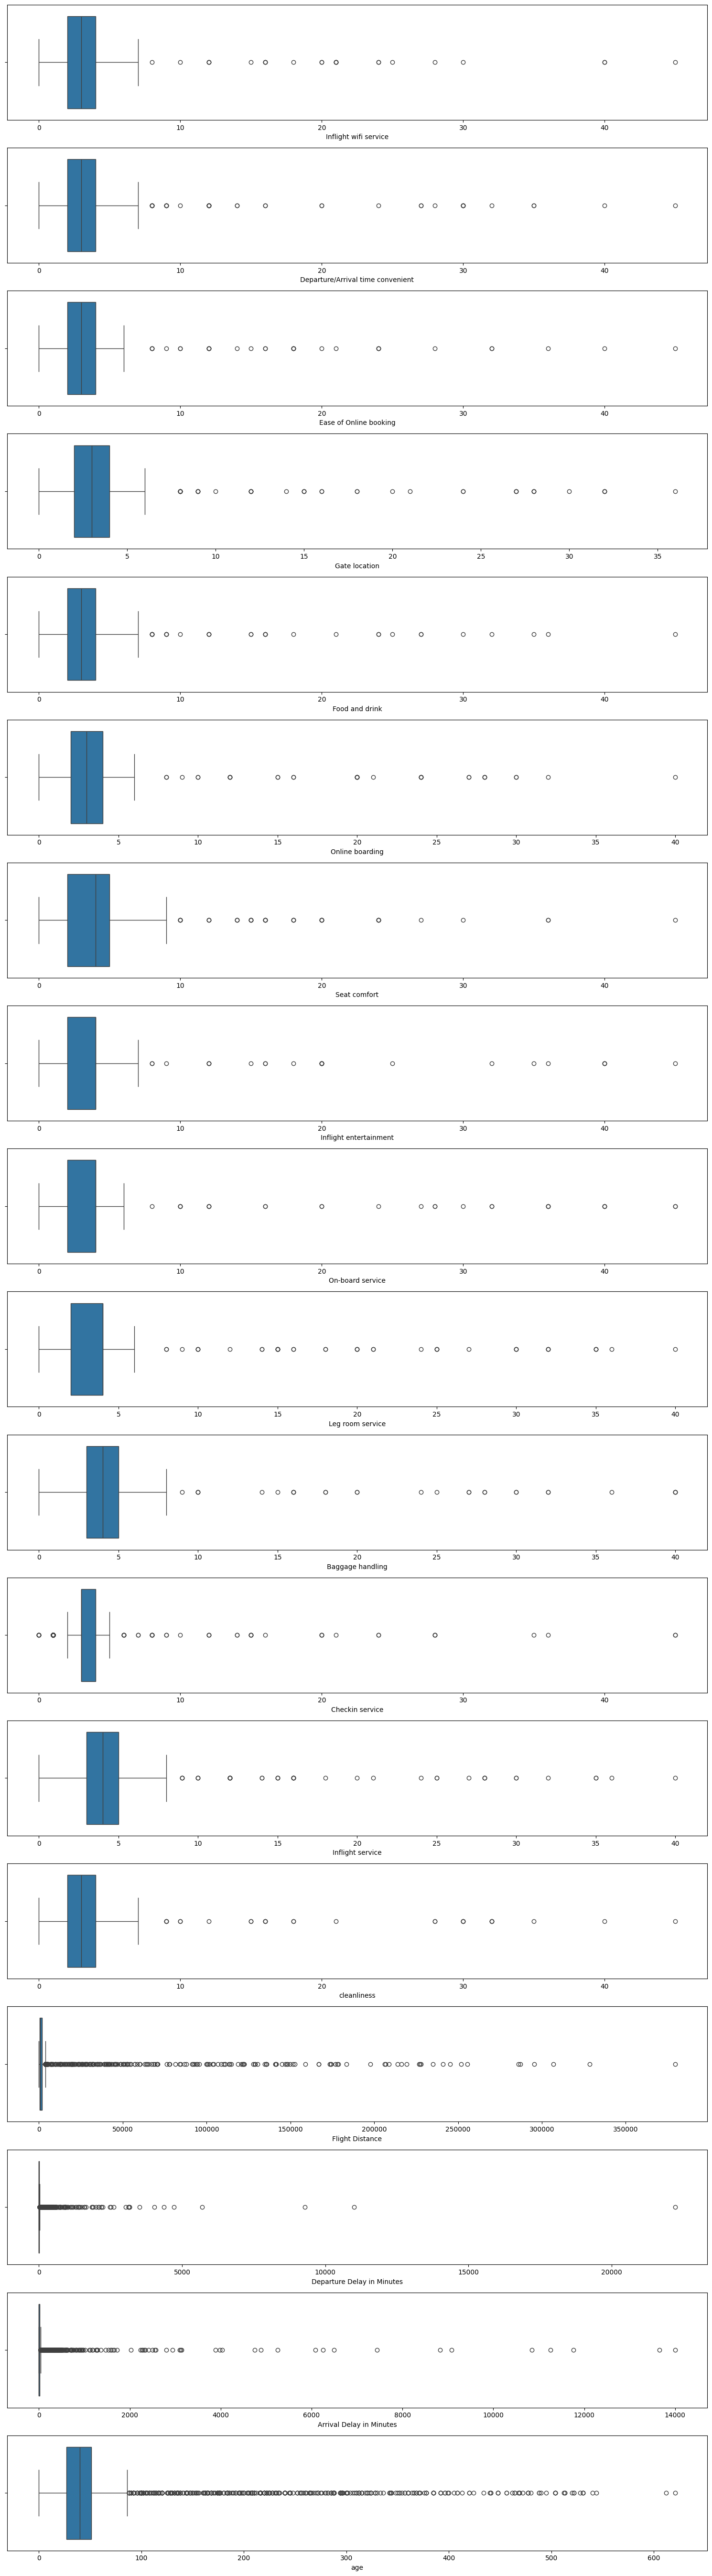

In [10]:
plt.figure(figsize=(15, len(columns_to_convert) * 3)) 

for i in range(len(columns_to_convert)):
    plt.subplot(len(columns_to_convert), 1, i + 1) 
    sns.boxplot(x=df[columns_to_convert[i]])

plt.tight_layout()
plt.show()

Выбросы в оснонвном наблюдаются в сторону более высоких значений, чем минимальных.

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

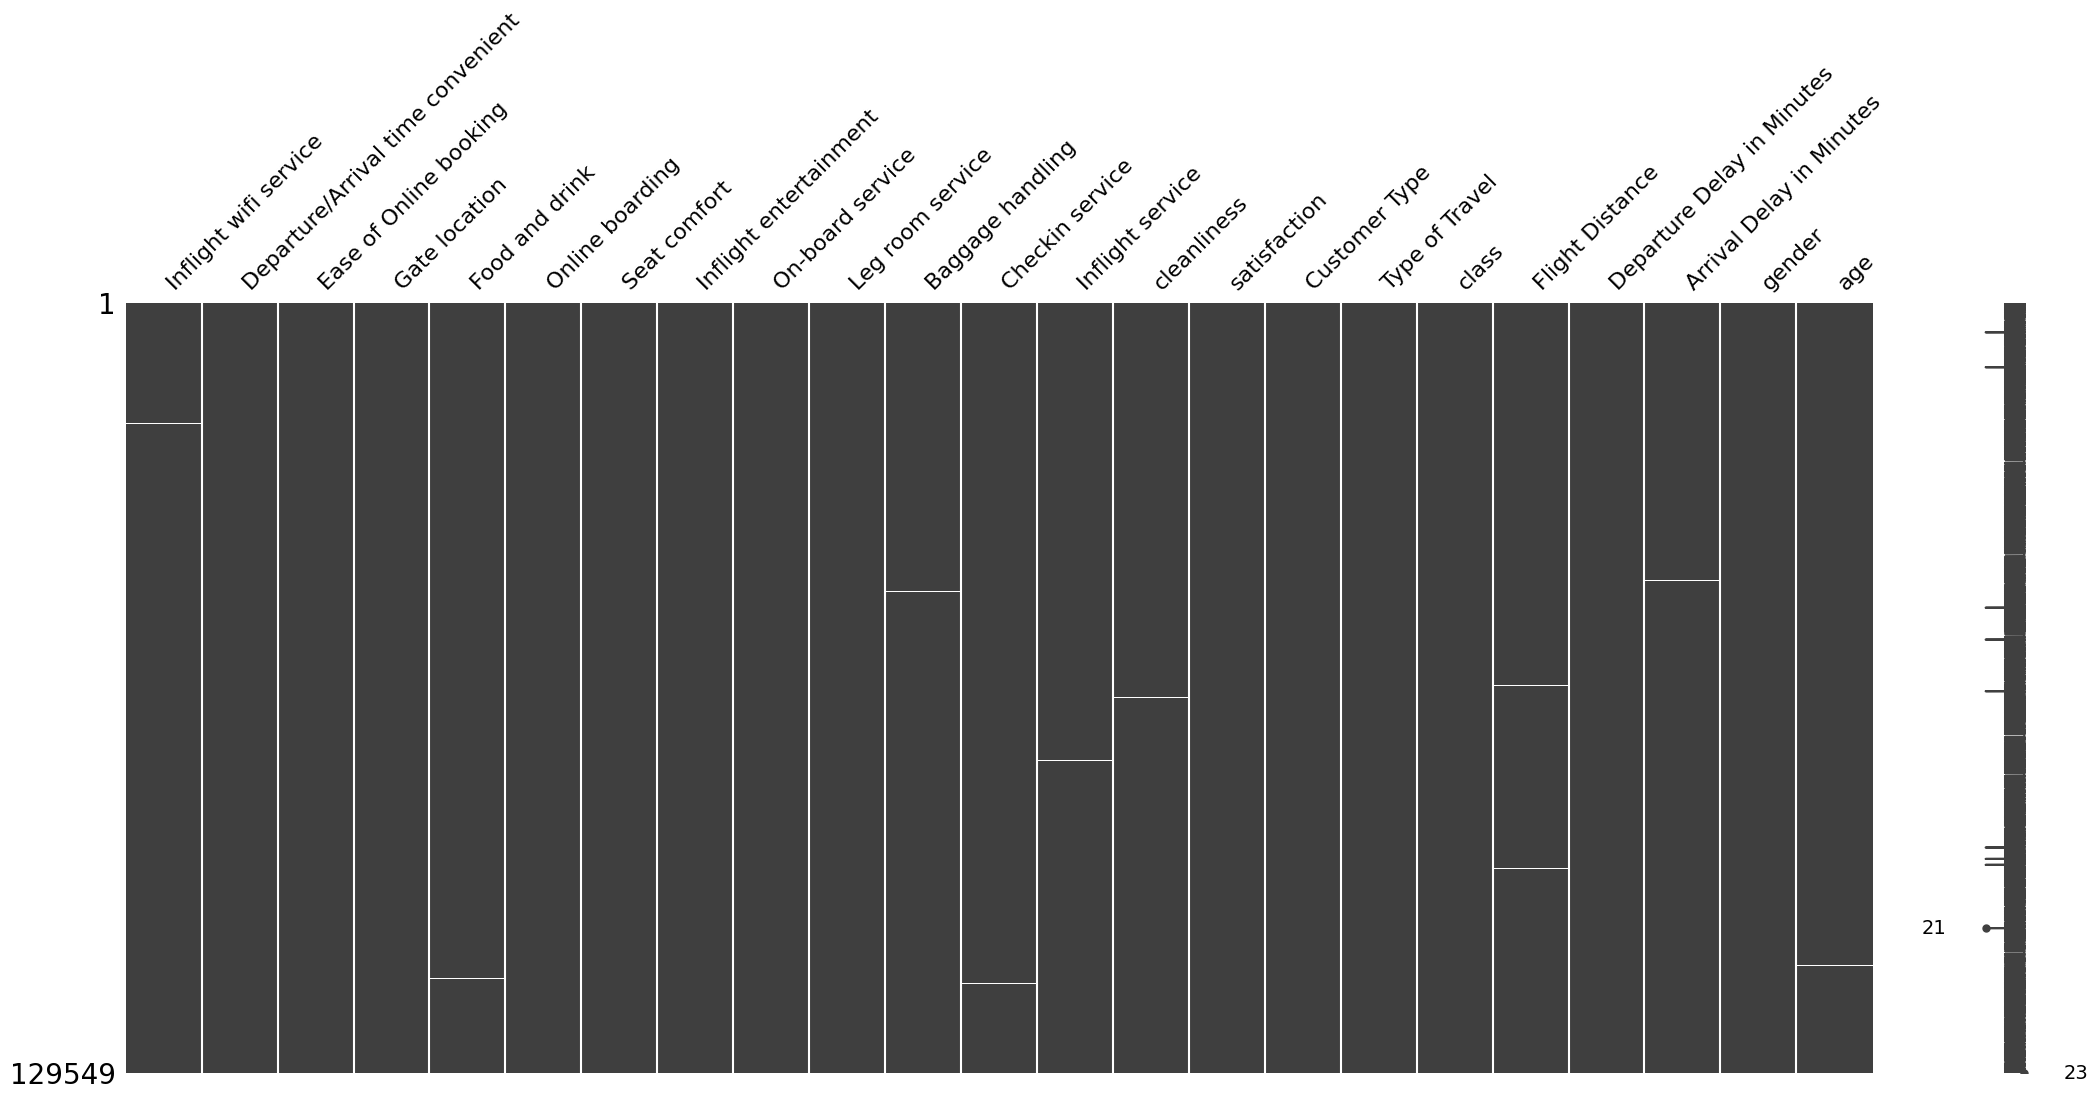

In [11]:
missingno.matrix(df)
plt.show()

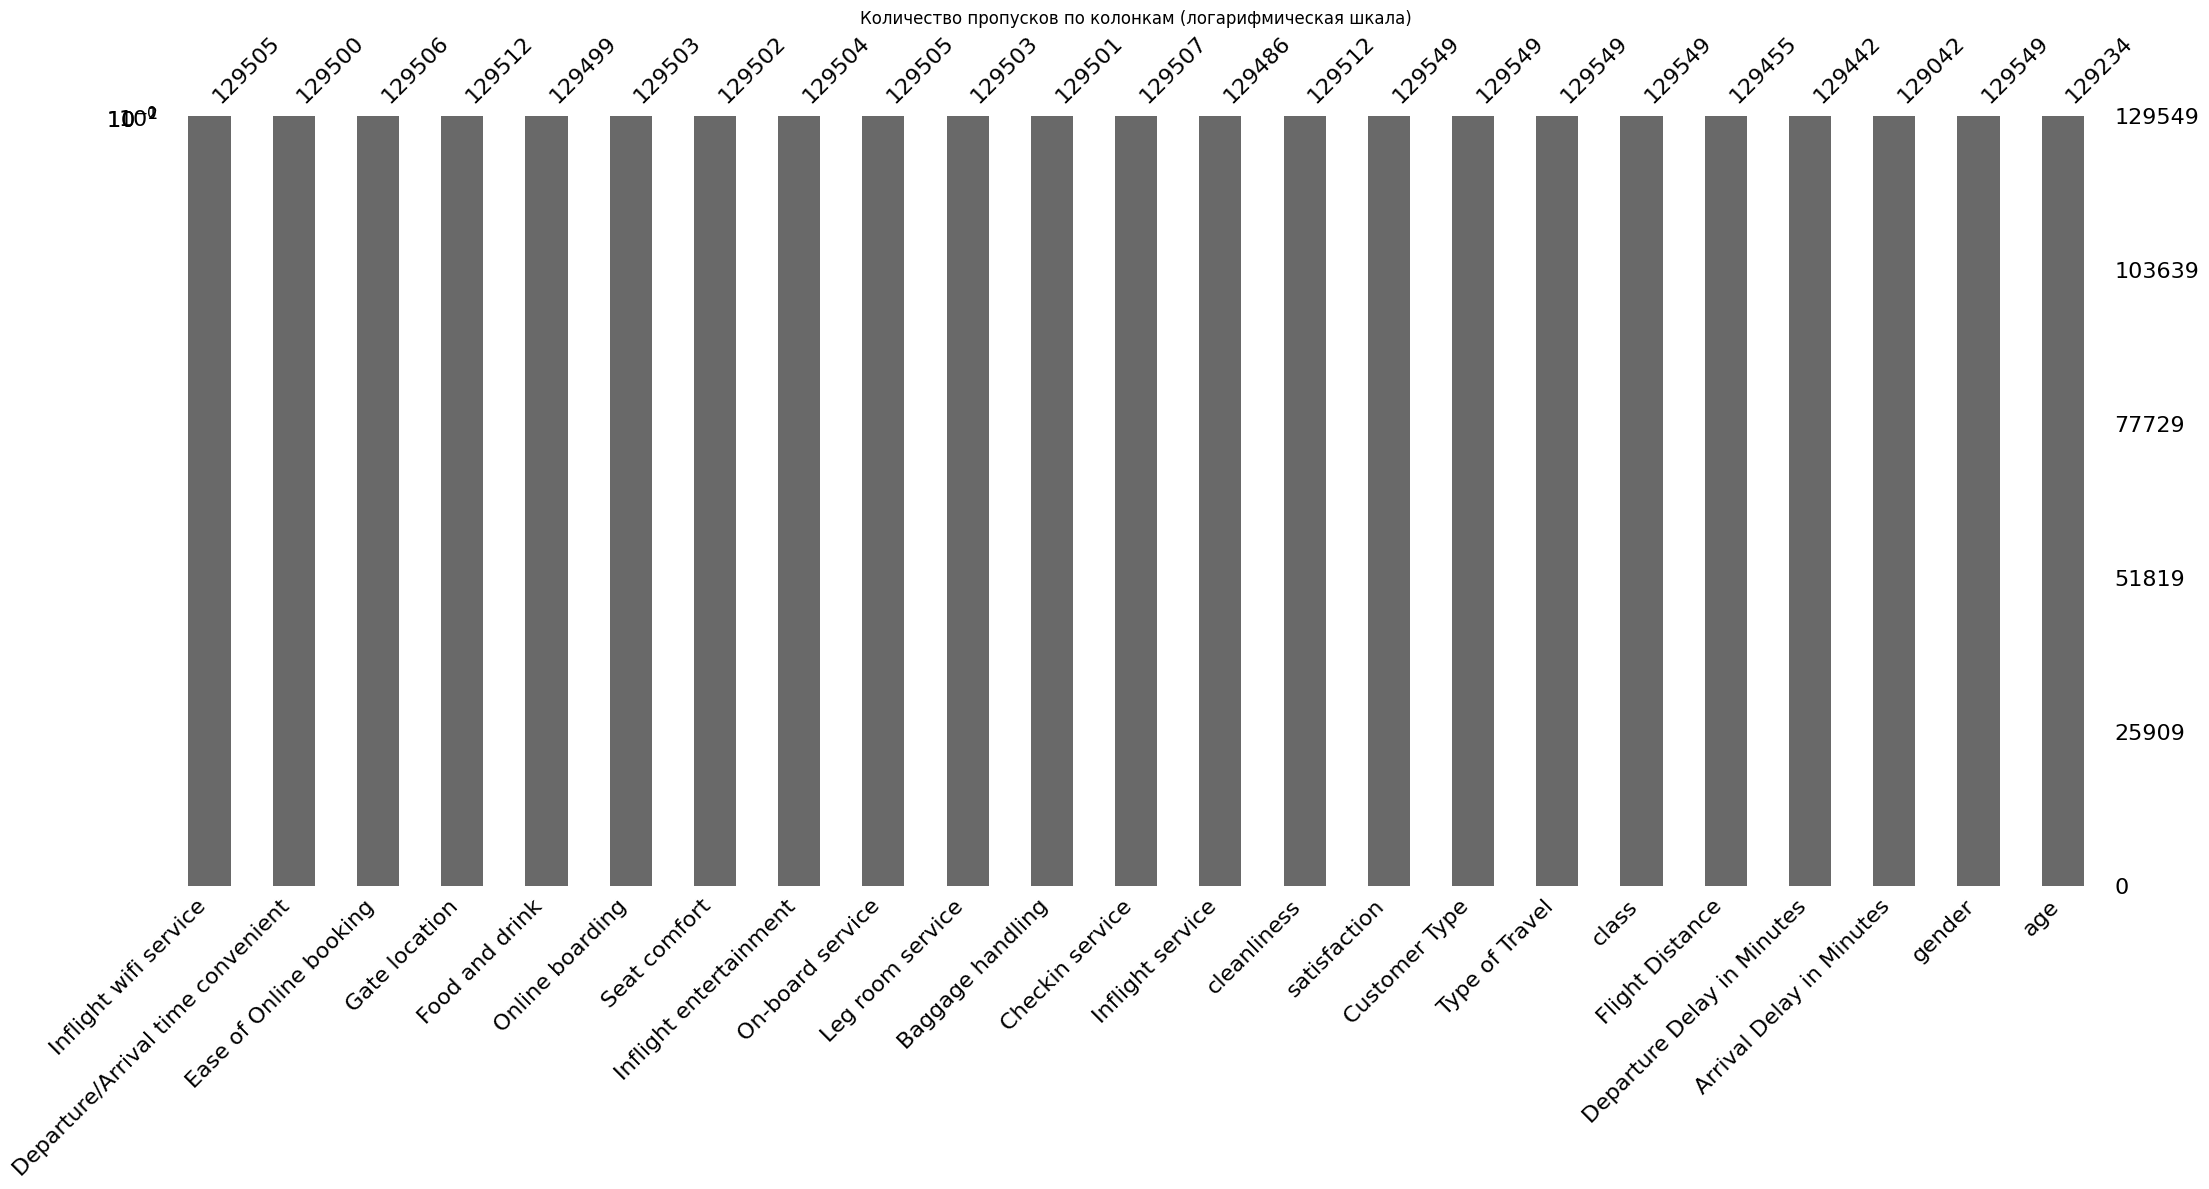

In [12]:
plt.figure(figsize=(10, 6))
missingno.bar(df)
plt.yscale('log') 
plt.title('Количество пропусков по колонкам (логарифмическая шкала)')
plt.show()


Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [13]:
df_train = df[df.satisfaction != '-']
df_train

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,cleanliness,satisfaction,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,gender,age
id,,,,,,,,,,,,,,,,,,,,,
7,3.0,3.0,3.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,...,4.0,satisfied,Loyal Customer,Business travel,Business,1963.0,0.0,0.0,Male,43.0
13,2.0,2.0,2.0,4.0,5.0,2.0,5.0,5.0,2.0,4.0,...,5.0,neutral or dissatisfied,disloyal Customer,Business travel,Eco,453.0,16.0,30.0,Male,24.0
18,2.0,5.0,2.0,1.0,4.0,1.0,5.0,5.0,5.0,2.0,...,1.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco,821.0,0.0,0.0,Female,61.0
31,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,4.0,5.0,...,2.0,neutral or dissatisfied,disloyal Customer,Business travel,Business,212.0,0.0,0.0,Male,35.0
39,3.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,4.0,...,5.0,satisfied,Loyal Customer,Business travel,Business,67.0,0.0,0.0,Female,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129831,1.0,3.0,1.0,5.0,3.0,1.0,3.0,3.0,1.0,1.0,...,3.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco,447.0,23.0,16.0,Female,28.0
129837,2.0,4.0,2.0,3.0,2.0,5.0,5.0,5.0,2.0,4.0,...,5.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco,337.0,199.0,213.0,Male,66.0
129838,3.0,5.0,3.0,4.0,2.0,5.0,5.0,3.0,3.0,3.0,...,4.0,neutral or dissatisfied,Loyal Customer,Personal Travel,Eco,308.0,32.0,24.0,Female,59.0


In [14]:
assert df_train.shape == (103_644, 23)

In [15]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,Inflight service,cleanliness,Customer Type,Type of Travel,class,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,gender,age
id,,,,,,,,,,,,,,,,,,,,,
55,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,...,3.0,2.0,Loyal Customer,Business travel,Business,3655.0,40.0,71.0,Male,36.0
79,5.0,4.0,0.0,3.0,4.0,4.0,4.0,3.0,3.0,0.0,...,3.0,5.0,Loyal Customer,Personal Travel,Eco,108.0,50.0,41.0,Female,70.0
126,2.0,5.0,2.0,4.0,5.0,2.0,5.0,5.0,3.0,5.0,...,5.0,5.0,Loyal Customer,Personal Travel,Eco,562.0,88.0,84.0,Male,66.0
199,4.0,4.0,4.0,4.0,2.0,4.0,5.0,4.0,4.0,4.0,...,4.0,5.0,Loyal Customer,Business travel,Business,3756.0,36.0,24.0,Female,60.0
263,1.0,2.0,1.0,3.0,2.0,3.0,3.0,2.0,2.0,1.0,...,2.0,1.0,Loyal Customer,Personal Travel,Business,802.0,0.0,0.0,Male,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129750,4.0,3.0,3.0,3.0,4.0,5.0,4.0,4.0,4.0,5.0,...,3.0,4.0,Loyal Customer,Business travel,Eco,337.0,92.0,82.0,Male,38.0
129771,3.0,4.0,3.0,3.0,1.0,3.0,5.0,1.0,4.0,2.0,...,4.0,1.0,Loyal Customer,Personal Travel,Eco,308.0,2.0,0.0,Male,16.0
129798,2.0,4.0,2.0,2.0,3.0,5.0,5.0,4.0,4.0,2.0,...,4.0,5.0,Loyal Customer,Personal Travel,Eco,308.0,0.0,0.0,Female,43.0


In [16]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [17]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [18]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [19]:
def fill_na_with_mode(df):
    df.replace('nan', np.nan, inplace=True)
    for col in df.columns:
        if df[col].dtype == 'object':
            mode = df[col].mode()
            if not mode.empty:
                df[col] = df[col].fillna(mode[0])
    return df

X_train = fill_na_with_mode(X_train)
X_val = fill_na_with_mode(X_val)

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [20]:
df.describe()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,cleanliness,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,age
count,129505.000000,129500.000000,129506.000000,129512.000000,129499.000000,129503.000000,129502.000000,129504.000000,129505.000000,129503.000000,129501.000000,129507.000000,129486.000000,129512.000000,129455.000000,129442.000000,129042.000000,129234.000000
mean,2.732327,3.062131,2.760722,2.981708,3.208141,3.256782,3.445669,3.361232,3.387259,3.355976,3.635872,3.309976,3.646927,3.289780,1322.922158,15.809026,16.656499,40.116951
std,1.360033,1.559627,1.431048,1.312873,1.357546,1.381888,1.349713,1.366908,1.335697,1.361670,1.222039,1.298827,1.218748,1.347466,4517.816532,93.276882,109.285072,20.376129
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,414.000000,0.000000,0.000000,27.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,846.000000,0.000000,0.000000,40.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1744.000000,12.000000,13.000000,51.000000
max,45.000000,45.000000,45.000000,36.000000,45.000000,40.000000,45.000000,45.000000,45.000000,40.000000,40.000000,45.000000,40.000000,45.000000,379620.000000,22227.000000,14006.000000,621.000000


In [21]:
df.describe(include=object)

,satisfaction,Customer Type,Type of Travel,class,gender
count,129549,129549,129549,129549,129549
unique,3,3,3,4,2
top,neutral or dissatisfied,Loyal Customer,Business travel,Business,Female
freq,58732,105763,89405,61939,65726


Во всех количественных переменных отмечается значительное количество выбросов. Это может привести как к искажению центральной тенденции, так и дисперсии:
* В колонке FlightDistance определенно есть некорректные значения: максимальное значение 379 620 невозможно. Длина экватора 24 901 миля, т.е чтобы достичь такого расстояния надо облететь планету 15 раз.
* В колонке Age аналогично есть некорректные значения: возраст пассажира не может быть 621 год
* Вероятно в колонке Departure Delay in Minutes с высокой вероятностью некорректные значения: задержка 22227 минут означает 15 дней задержки рейса. Такое маловероятно.
* В признаках, характеризующих оценки максимальное значение - 45. Данное значение либо является дефектом данных, либо тот кто его выставил хотел поставить 4,5.

В целом, учитывая ранее проведенный графический и количественный анализ, доля выбросов незначительна относительно количества наблюдений. Для последующего анализа они могут быть удалены.

### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [22]:
for col in X_train.select_dtypes(include=[np.number]).columns:
    q = X_train[col].quantile(0.996)
    mask = X_train[col] <= q
    X_train = X_train[mask]
    y_train = y_train[mask]

for col in X_val.select_dtypes(include=[np.number]).columns:
    q = X_val[col].quantile(0.996)
    mask = X_val[col] <= q
    X_val = X_val[mask]
    y_val = y_val[mask]

In [23]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [24]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[1:]

In [25]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [26]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    num_cols = len(cols)
    n_rows = (num_cols + 3) // 4
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(16, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.countplot(x=col, hue=y, data=df, ax=axes[i])
        axes[i].set_title(f'Countplot of {col}', fontsize=14)

    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [27]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    num_cols = len(cols)
    n_rows = (num_cols + 3) // 4
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(16, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(data=df, x=col, hue=y, ax=axes[i], kde=True)
        axes[i].set_title(f'Histplot of {col}', fontsize=14)

    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [28]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    num_cols = len(cols)
    n_rows = (num_cols + 3) // 4
    
    fig, axes = plt.subplots(n_rows, 4, figsize=(16, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.countplot(x=col, hue=y, data=df, ax=axes[i])
        axes[i].set_title(f'Countplot of {col}', fontsize=14)

    for j in range(num_cols, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


Отрисовка.

In [29]:
X_train['Customer Type'].value_counts()

Customer Type
Loyal Customer       57509
disloyal Customer    12765
Name: count, dtype: int64

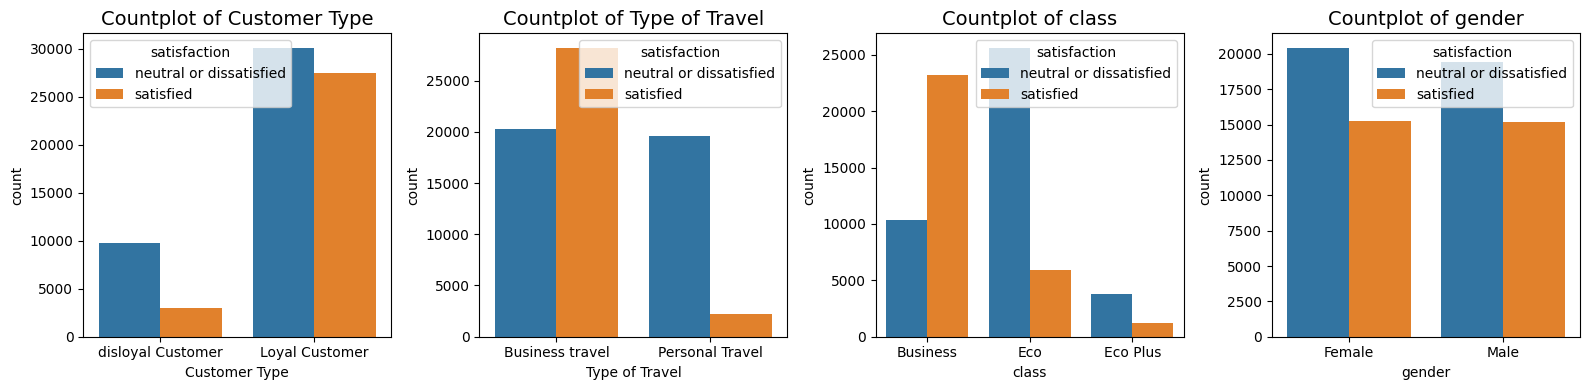

In [30]:
plot_categorical(categorical_cols, X_train, y_train)

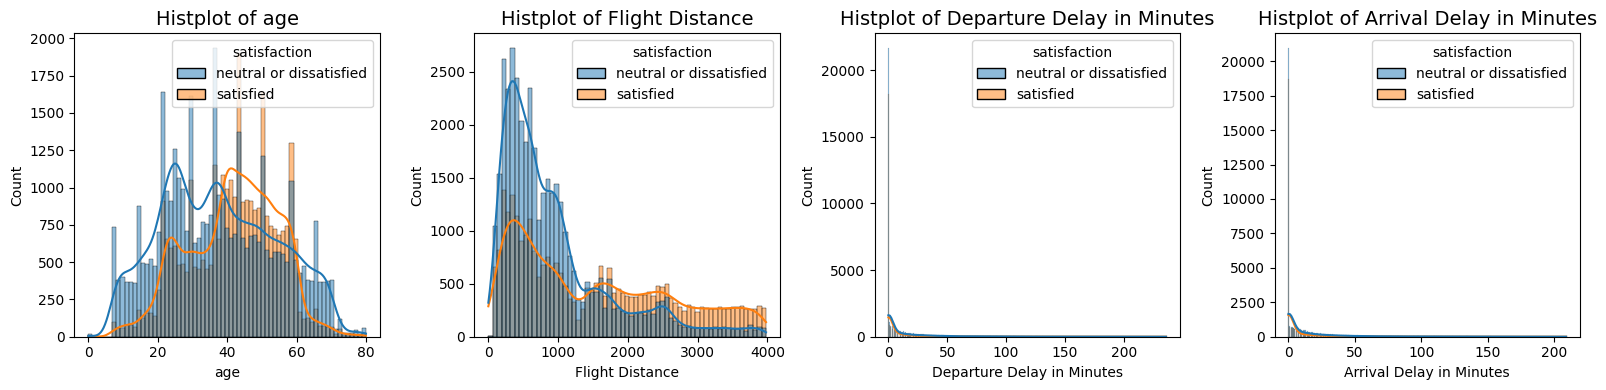

In [31]:
plot_continuous(continuous_cols, X_train, y_train)

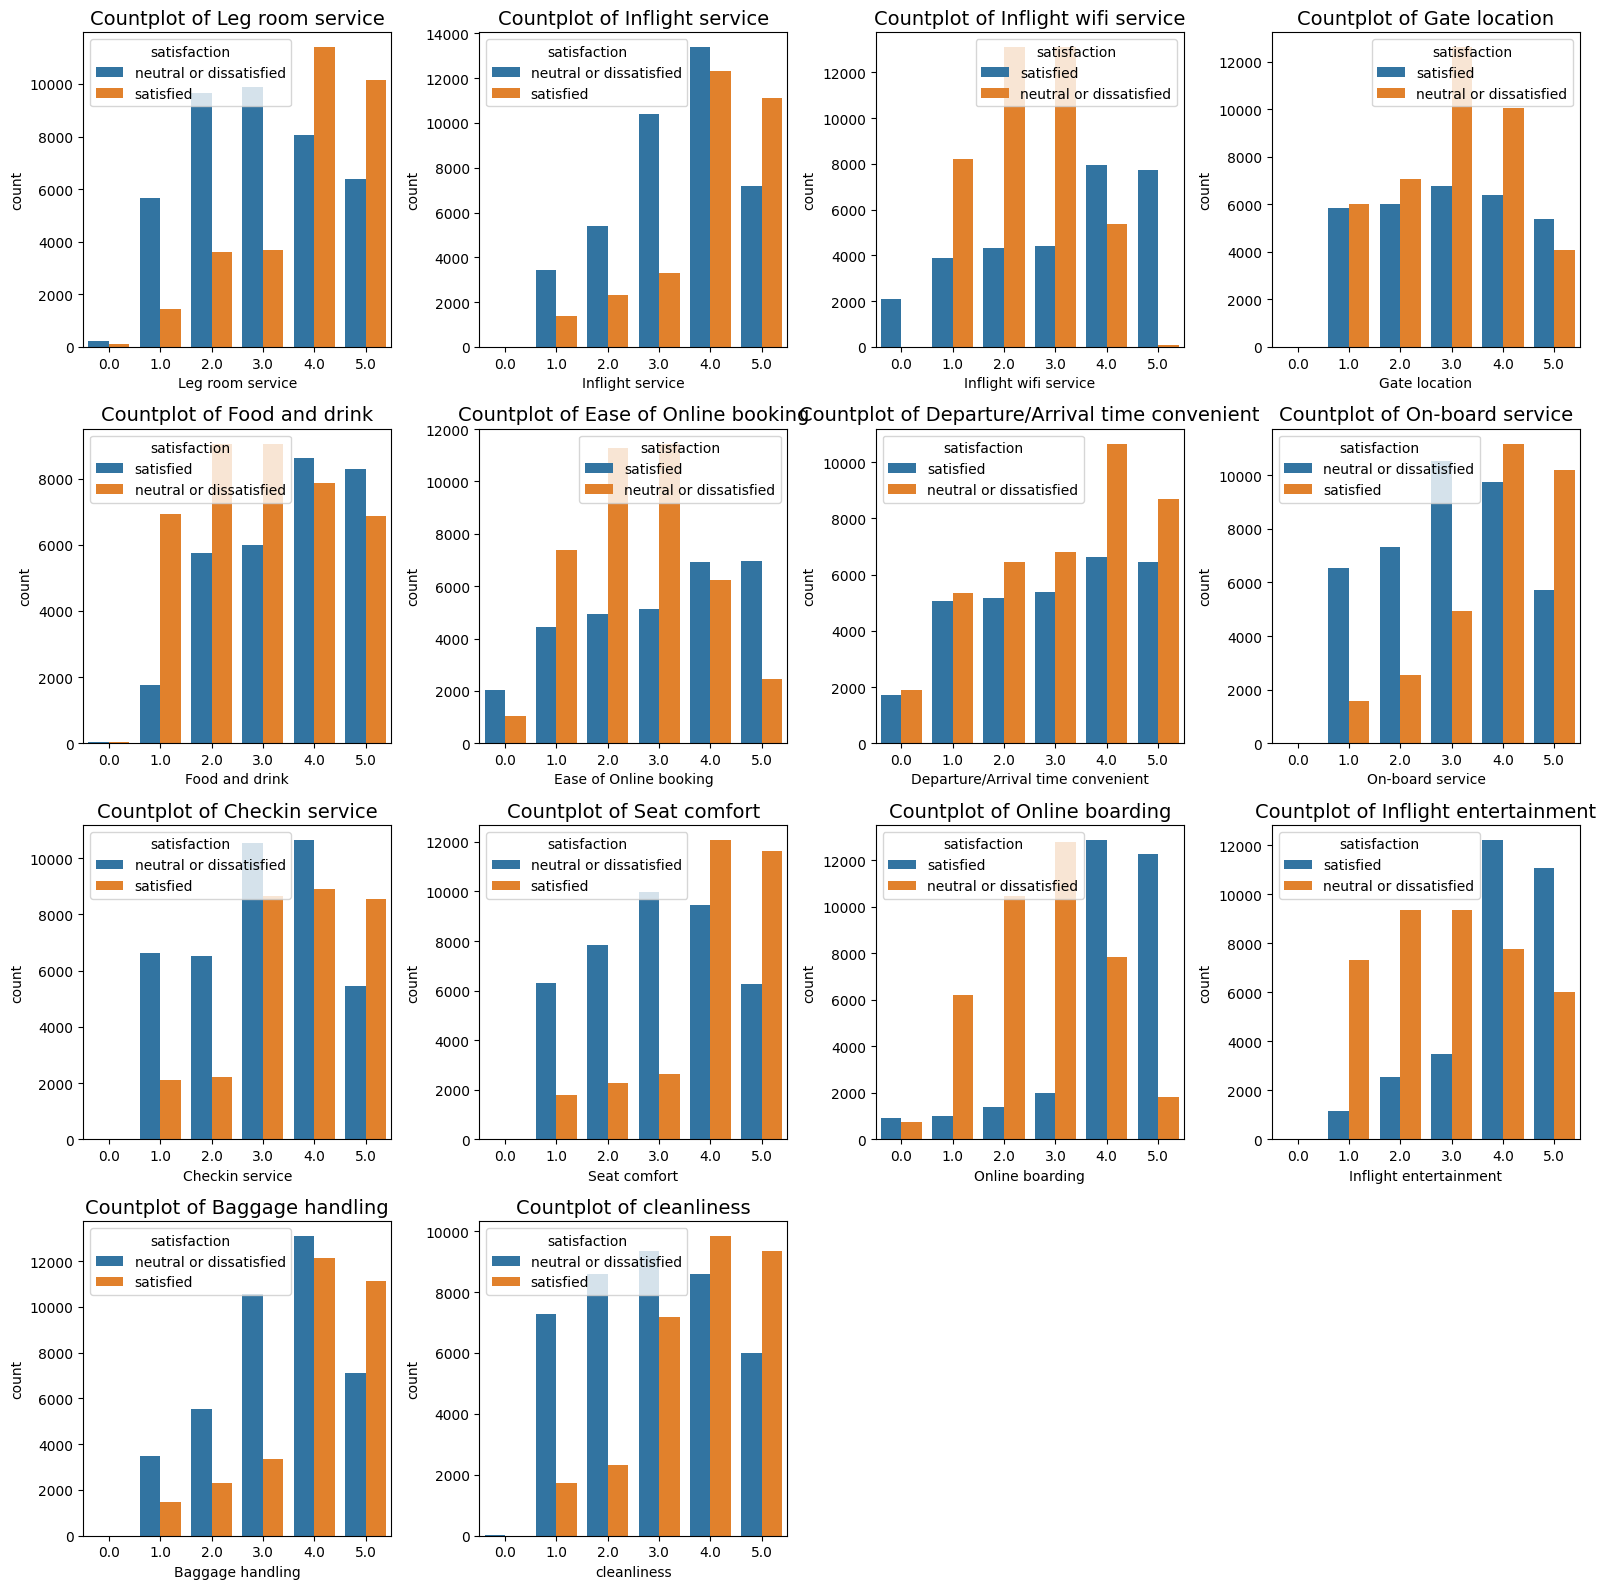

In [32]:
plot_ordinal(ordinal_cols, X_train, y_train)

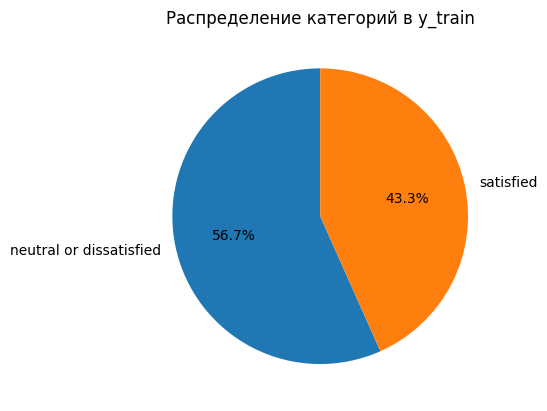

In [33]:
category_counts = pd.Series(y_train).value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%.1f%%', startangle=90)
plt.title("Распределение категорий в y_train")
plt.show()

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

**Выводы по количественным признакам:**
* Распределение данных по полу выглядит нормально, в то время как распределение по длительности полета демонстрирует значительную правостороннюю асимметрию. Большинство рейсов находится в диапазоне 0-1000 миль, но встречаются и значительные значения.
* Распределение данных о задержках вылета и прибытия также имеет правостороннюю асимметрию и высокий эксцесс. Большая часть рейсов вылетает либо без задержки, либо с небольшой задержкой, в то время как случаи значительных задержек редки. Это приводит к низкой дисперсии.
* Возраст может оказывать влияние на удовлетворенность: средний возраст пассажиров, довольных полетом, выше, чем у тех, кто остался неудовлетворенным или нейтральным.
* В целом можно сказать, что чем короче рейс, тем больше количество неудовлетворенных и нейтральных пассажиров. С увеличением расстояния полета растет и число удовлетворенных пассажиров. Это может быть связано с тем, что на коротких рейсах часто меньше комфорта и качества сервиса (например, отсутствие питания и развлекательных систем).
* Существовала гипотеза о том, что длинные перелеты чаще ассоциируются с отпускными поездками, что способствует хорошему настроению пассажиров. В то же время короткие рейсы обычно связаны с деловыми поездками, что может снижать уровень удовлетворенности. Однако эта гипотеза не подтверждается данными: количество удовлетворенных пассажиров в бизнес-поездках значительно выше, чем в частных.

**Выводы по качественным признакам:**
* Очевидно, что доля удовлетворенных пассажиров в бизнес-классе значительно выше, чем в эконом-классе.
* Существенной разницы в уровне удовлетворенности по половому признаку не наблюдается.
* Значительный дисбаланс классов проявляется в частных поездках среди нелояльных клиентов и в зависимости от выбранного класса обслуживания.

**Выводы по порядковым признакам:**
* Очевидно, что чем выше оценки за услуги во время полета, тем больше количество удовлетворенных пассажиров и меньше тех, кто остается нейтральным или недовольным.
* Можно предположить, что качество посадки не так критично: уровень удовлетворенности пассажиров распределен довольно равномерно в зависимости от оценок посадки, и значительного роста удовлетворенности не наблюдается.

**Выводы по распределению таргета:**
* Отмечается, что классы относительно сбалансированны (56,6% vs 43.4%). Следовательно возможно использование как Accuracy в качестве метрики классификации, так и иных (f1, roc-auc, gini)
* Из распределения порядковы признаков можно предположить, что процент "неудовлетворенных" в классе "нейтральные и неудовлетворенные" не столь велик.

### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

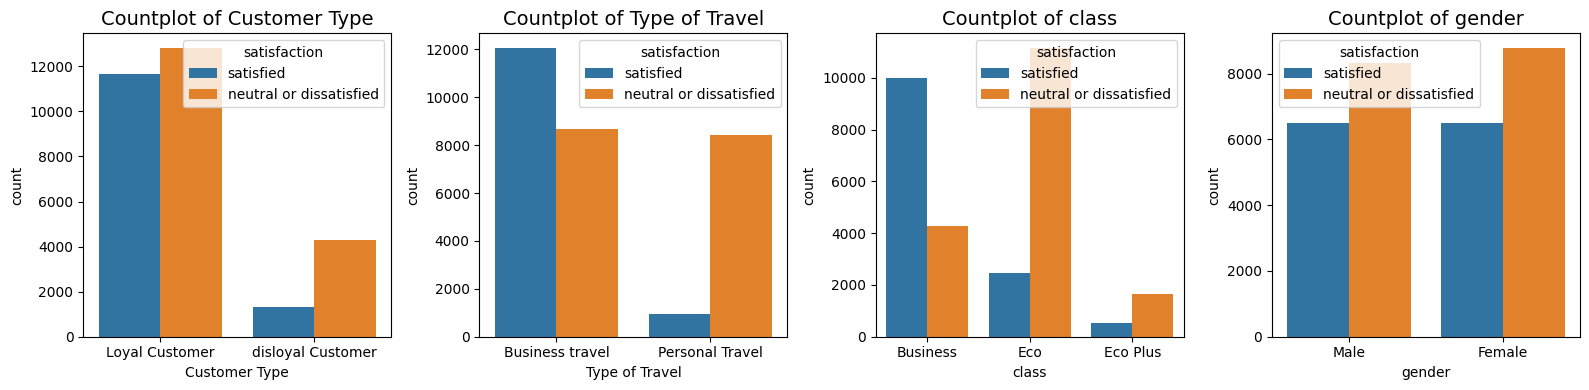

In [34]:
plot_categorical(categorical_cols, X_val, y_val)

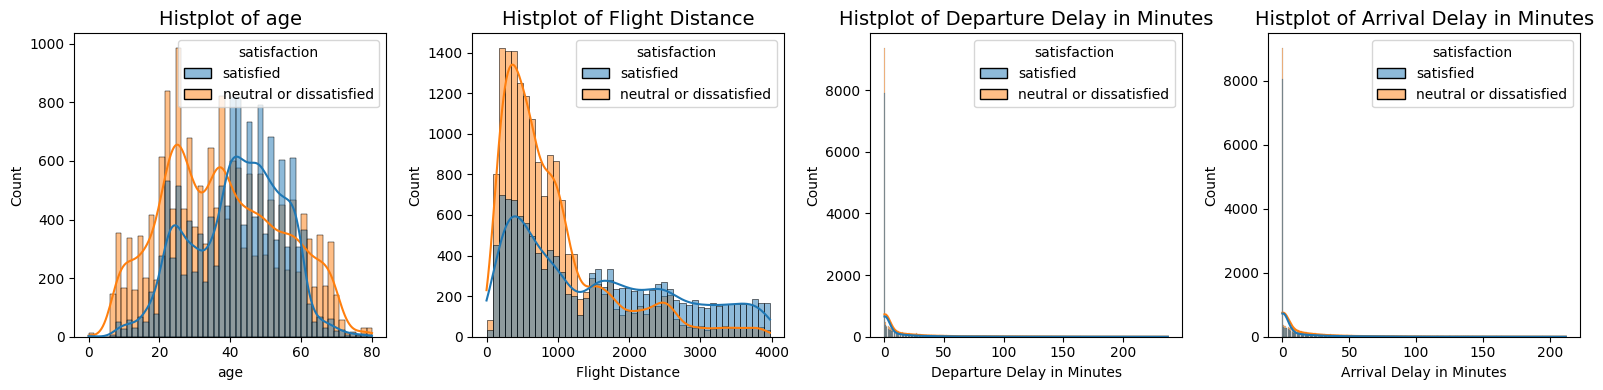

In [35]:
plot_continuous(continuous_cols, X_val, y_val)

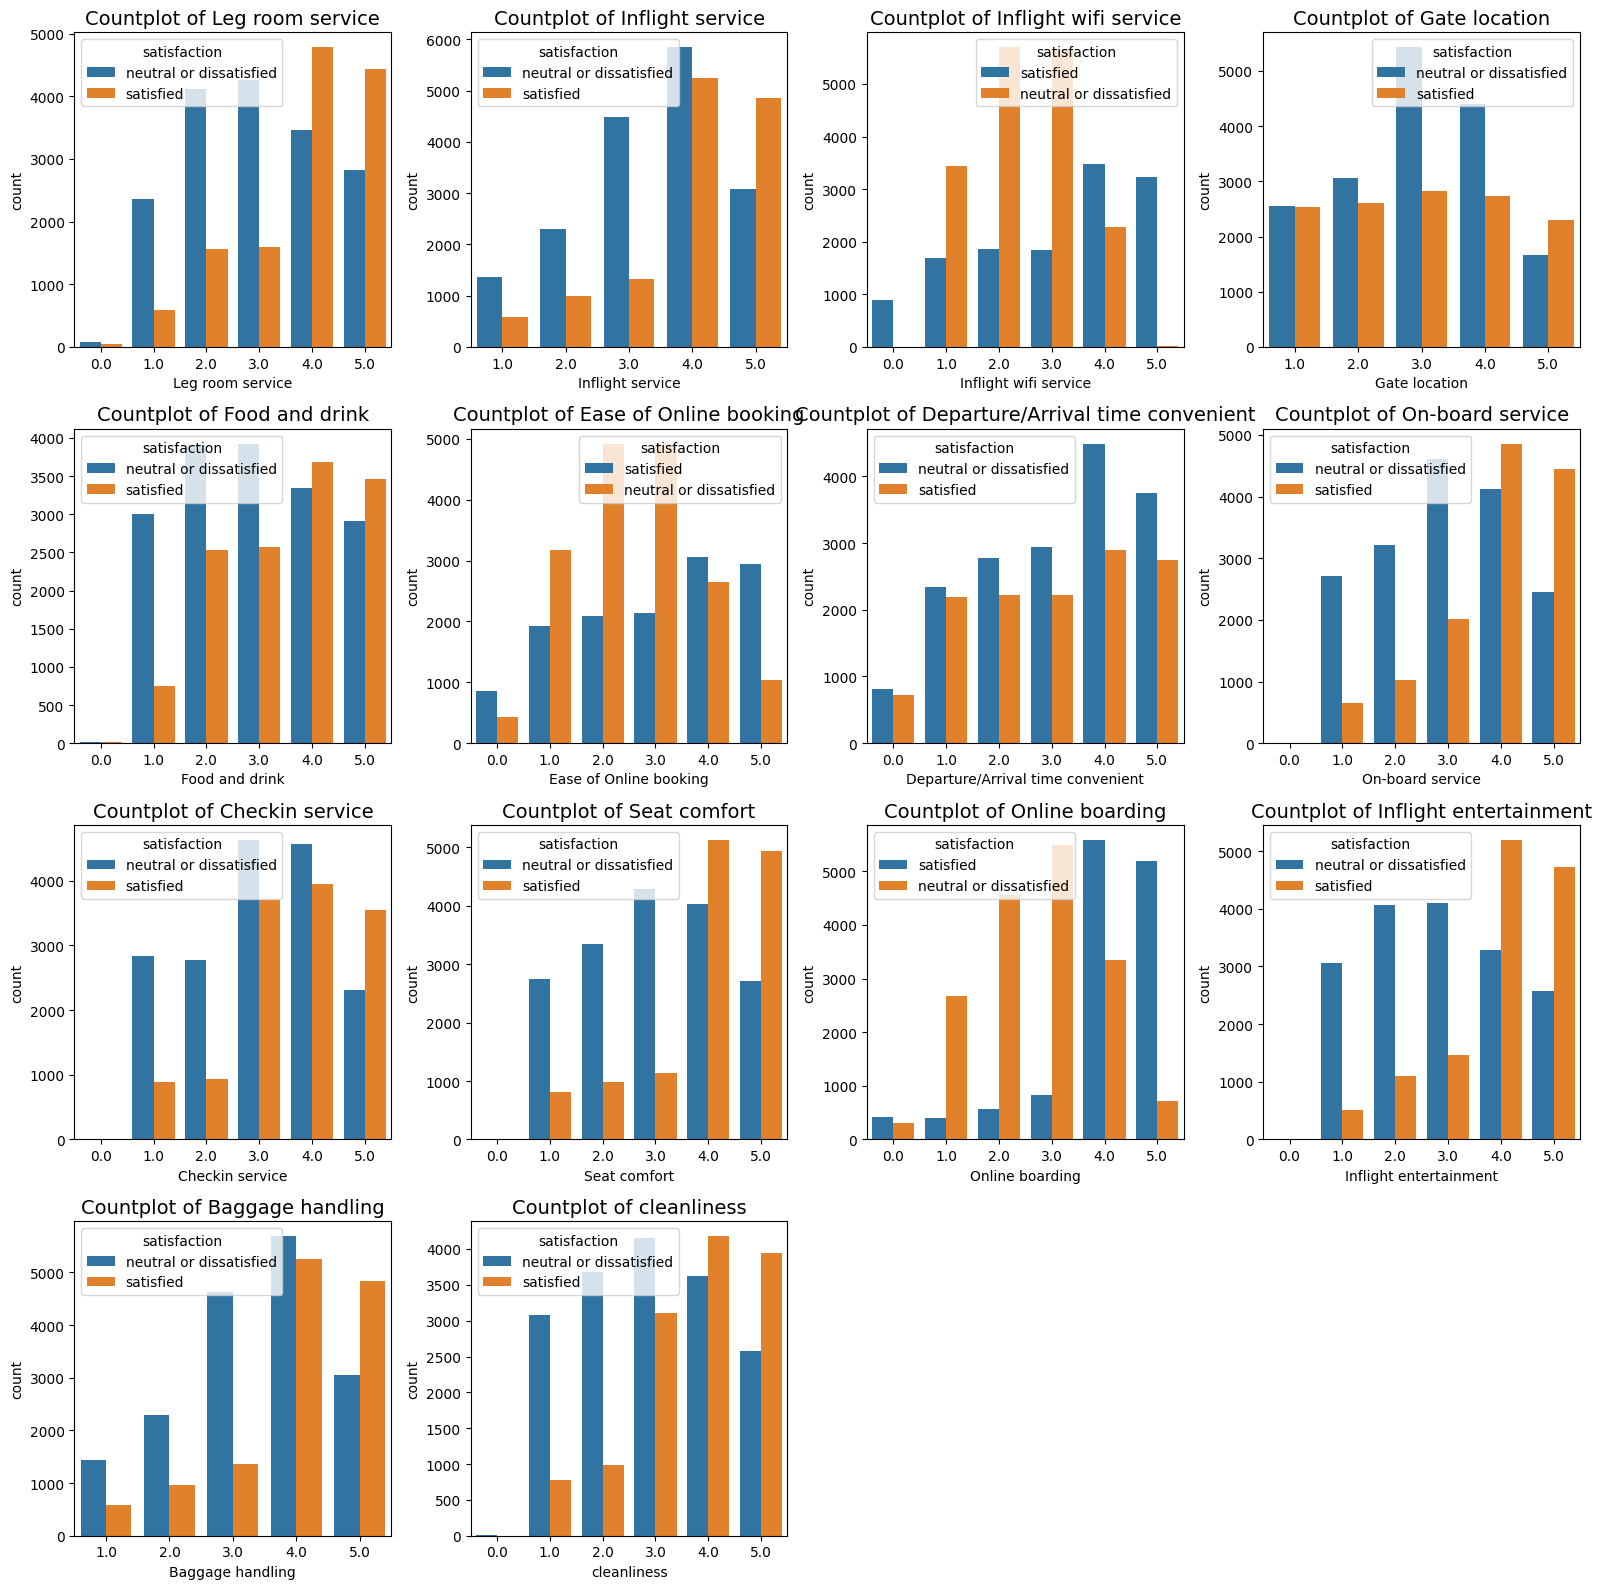

In [36]:
plot_ordinal(ordinal_cols, X_val, y_val)

**Вывод:** По итогам визуального анализа распределение целевой переменной как по количественнным, так и по качественным и по порядковым признакам схожи для тренировочной и валидационной выборки. 

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [37]:
epsilon = 1e-2
X_train['Arrival Delay in Minutes'] = np.log(X_train['Arrival Delay in Minutes'] + epsilon)
X_train['Departure Delay in Minutes'] = np.log(X_train['Departure Delay in Minutes'] + epsilon)

Построение.

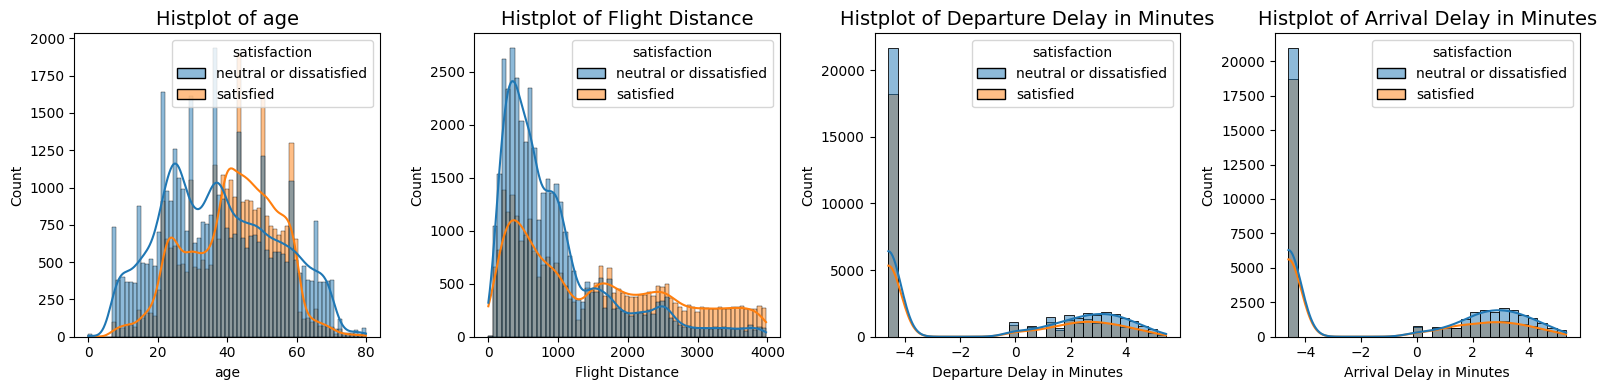

In [38]:
plot_continuous(continuous_cols, X_train, y_train)

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

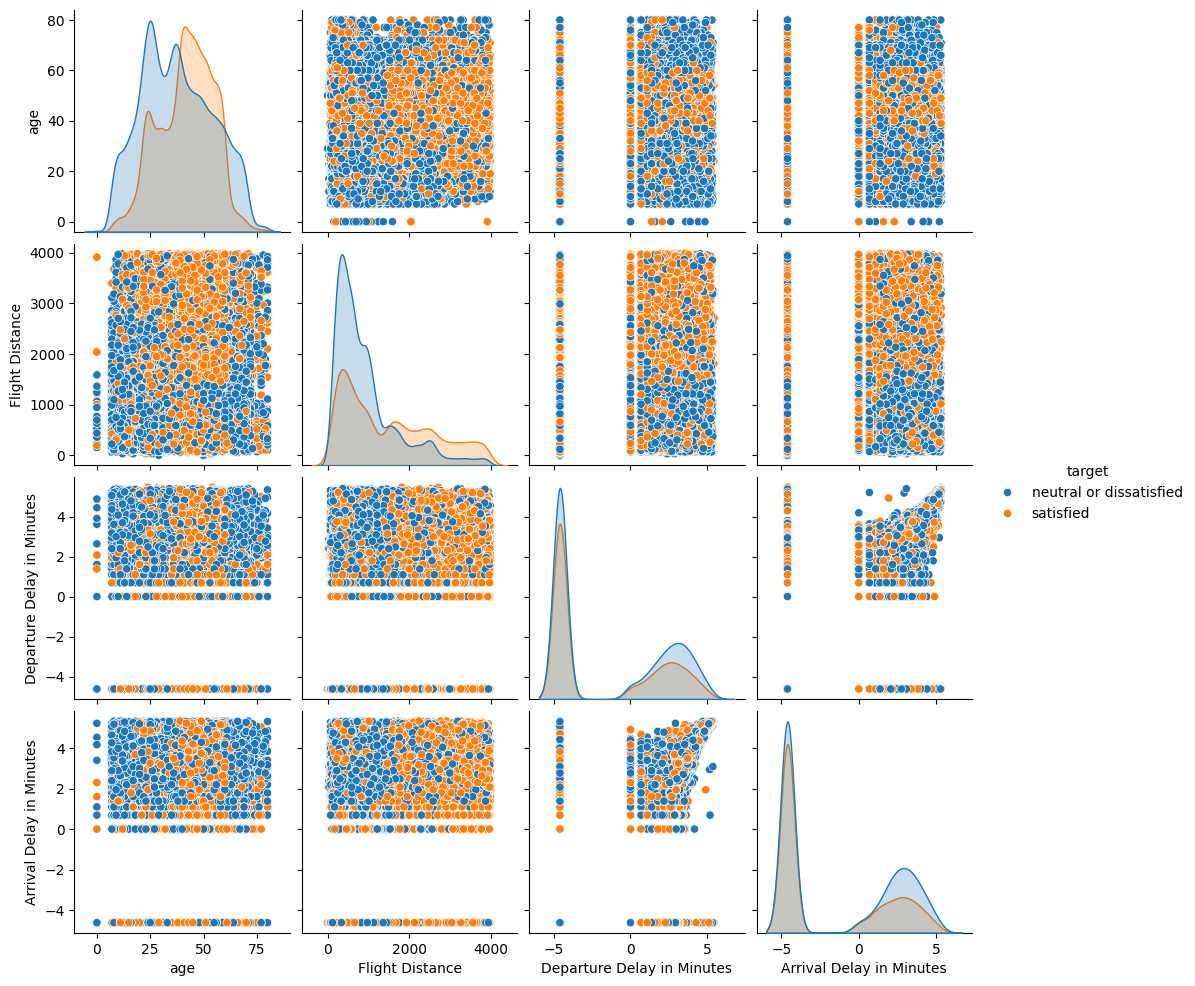

In [39]:
X_train_2 = X_train.copy() 
X_train_2['target'] = y_train 

sns.pairplot(X_train_2[continuous_cols + ['target']], hue='target') 
plt.show()

В целом pairplot показывает результаты, аналогичные ранее проведенному анализу.

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [40]:
y_train = np.where(y_train == 'satisfied', 1, 0)
y_val = np.where(y_val == 'satisfied', 1, 0)

In [41]:
from sklearn.compose import ColumnTransformer

ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

preproc = ColumnTransformer([
    ('ohe', ohe)
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe, categorical_cols),
        ('num', 'passthrough', continuous_cols),
        ('ord', 'passthrough', ordinal_cols) 
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [42]:
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [43]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

print(accuracy_score(y_true=y_val, y_pred=y_pred))

0.9335326357747883


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [44]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    dt,
    X_train,
    y_train,
    X_val,
    y_val,
    loss='0-1_loss',
    num_rounds=100
)
print(f"bias: {bias_dt:.4f}, variance: {var_dt:.4f}")

bias: 0.0430, variance: 0.0584


Variance получился более высоким, чем bias. Типичная ситуация для решающих деревьев.

### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [45]:
print(f'Глубина дерева: {dt.get_depth()}')
print(f'Количество листьев: {dt.get_n_leaves()}')

Глубина дерева: 35
Количество листьев: 2082


Дерево получилось достаточно сложным. Глубина дерева насчитывает 30 уровней. С высокой вероятность дерево переобучено.

### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

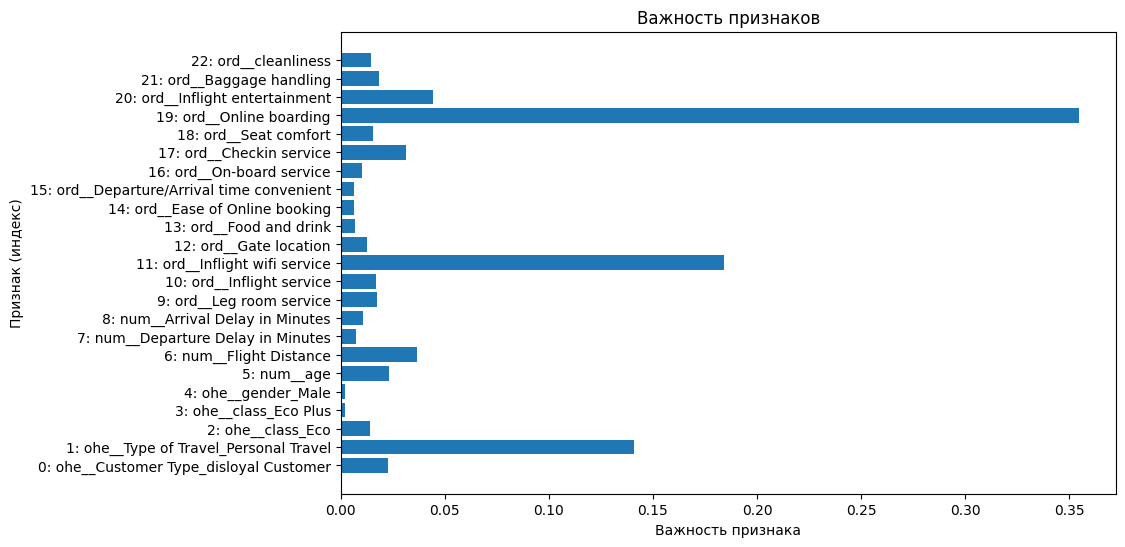

In [46]:
feature_importances = dt.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

indexed_feature_names = [f"{i}: {name}" for i, name in enumerate(feature_names)]

plt.figure(figsize=(10, 6))
plt.barh(indexed_feature_names, feature_importances, align='center')
plt.xlabel("Важность признака")
plt.ylabel("Признак (индекс)")
plt.title("Важность признаков")
plt.show()

Наиболее информативными признаками оказались: тип поездки, наличие wi-fi на борту, онлайн-регистрация, качество развлечений, расстояние полета

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [47]:
X_selected_train = X_train[:, [9, 21]]
X_selected_val = X_val[:, [9, 21]]

In [48]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_selected_train, y_train)

y_pred = model.predict(X_selected_val)

print(accuracy_score(y_true=y_val, y_pred=y_pred))

0.7197807673143995


Accuracy для такого дерева получился несколько ниже на валидационной выборке.

### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

In [49]:
import graphviz

dot_data = export_graphviz(model, out_file=None,
                           feature_names=['inflight_wifi_service', 'online_boarding'],
                           class_names=[str(cls) for cls in model.classes_],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("decision_tree")
graph.view()

'decision_tree.pdf'

Предикаты не целые, а кратные 0.5 потому что фичи являются порядковыми и принимают целые значения 1, 2, 3, 4, 5. Для того, чтобы подобрать порог классификации алгоритм дерева устанавливает порог разбиения посередине между 1 и 2 или 3 и 4 и тп.

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

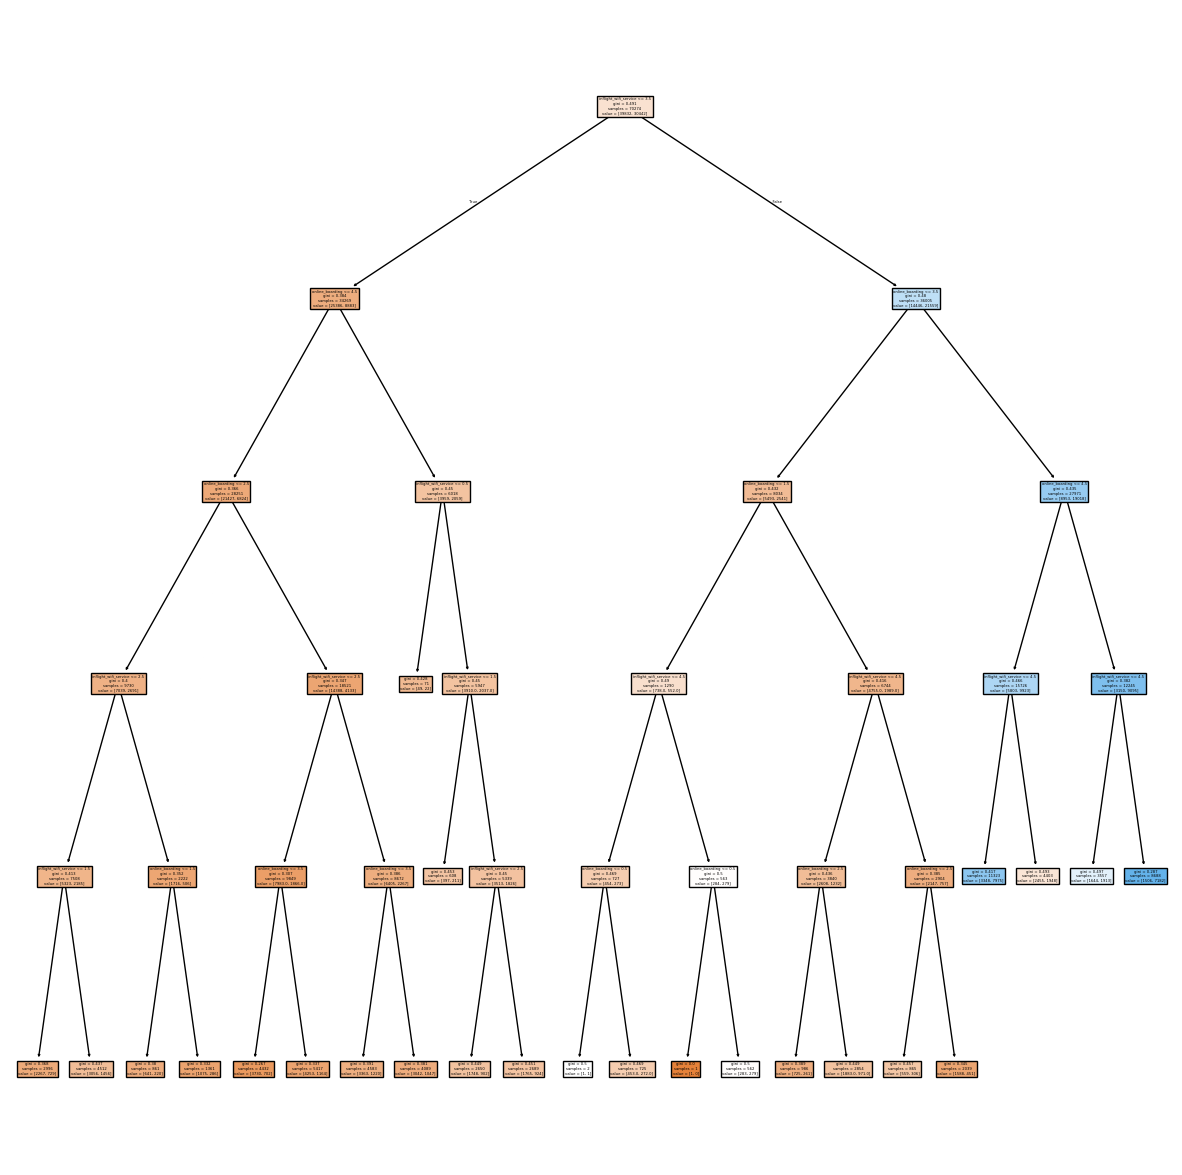

In [50]:
plt.figure(figsize=(15, 15))
plot_tree(model, filled=True, feature_names=['inflight_wifi_service', 'online_boarding'], impurity=True)
plt.show()

Дерево получилось несимметричным (самая правая ветвь значительно короче остальных). С одной стороны такие деревья более точные, поскольку более гибко адаптируются к данным, с другой стороны более склонны к переобучению.

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

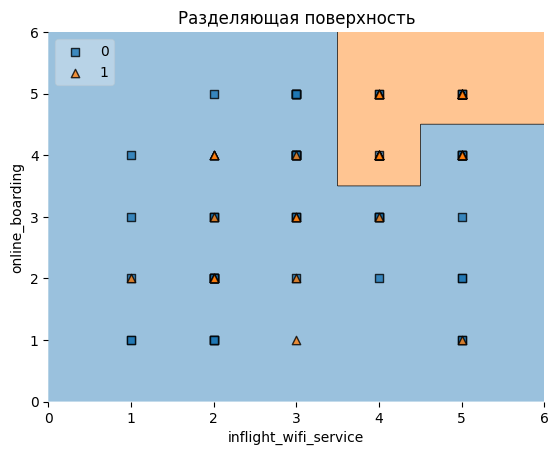

In [51]:
plot_decision_regions(X_selected_train[:100, [0, 1]], y_train[:100], clf=model, legend=2)

plt.xlabel('inflight_wifi_service')
plt.ylabel('online_boarding')
plt.title('Разделяющая поверхность')
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [52]:
# # замените X_train_example на вашу переменную

# fig, ax = plt.subplots(3, 3, figsize=(20, 20))

# for row in range(3):
#     for col in range(3):
#         inds = np.random.choice(X_selected_train.index, size=X_selected_train.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

#         tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
#         tree_exp.fit(X_selected_train.loc[inds, :], y_train[inds])

#         plot_decision_regions(clf=tree_exp, X=np.array(X_selected_train.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [53]:
# # замените X_train_example на вашу переменную (ohe-encoded)

# %%time
# depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

# accuracies_train = []
# accuracies_test = []
# for max_depth in depths:
#     DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
#     DT.fit(X_train, y_train)
#     y_predicted_train = DT.predict(X_train)
#     y_predicted_val = DT.predict(X_val)
#     accuracies_train.append(accuracy_score(y_train, y_predicted_train))
#     accuracies_test.append(accuracy_score(y_val, y_predicted_val))

In [54]:
# plt.figure(figsize=(12, 8))
# plt.plot(depths, accuracies_train, depths, accuracies_test)
# plt.legend(['train', 'test'])
# plt.ylabel('accuracy')
# plt.xlabel('max_depth')
# plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [55]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 21)
}

model = DecisionTreeClassifier()

gs_tree = GridSearchCV(model, parameters, cv=5, n_jobs=-1)
gs_tree.fit(X_train, y_train)

print("Best parameters:", gs_tree.best_params_)
print("Best score:", gs_tree.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 14}
Best score: 0.9482169415453339


In [56]:
# проверим качество на валидационной выборке

model = DecisionTreeClassifier(criterion='entropy', max_depth=14)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(accuracy_score(y_true=y_val, y_pred=y_pred))

0.9452914798206278


Подбор гиперпараметров позволил улучшить Accuracy. С параметрами по усолчанию Accuracy составлял 0.932, после подбора 0.945.

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [57]:
# with open('DT.pkl', 'wb') as f:
#     pickle.dump(model, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [58]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(accuracy_score(y_true=y_val, y_pred=y_pred))

0.9605381165919282


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

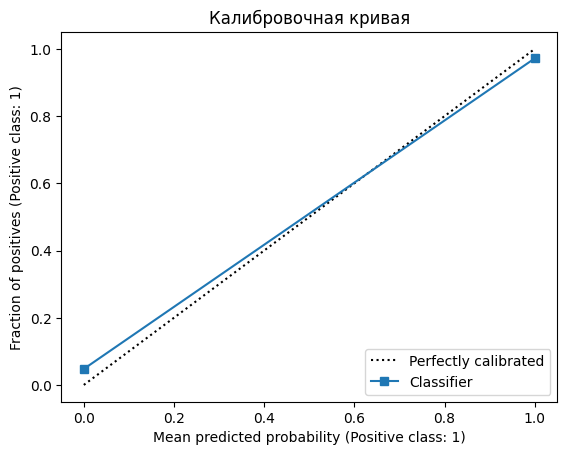

In [59]:
disp = CalibrationDisplay.from_predictions(y_val, y_pred, n_bins=10)
plt.title("Калибровочная кривая")
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

```
Ответ: Не очень корректно, потому что деревья имеют сложную нелинейную структуру, плюс вероятность определяется наибольшей долей объектов i-го класса, что может быть далеким от реальной вероятности значением. Нужна калибровка деревьев.
```

### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

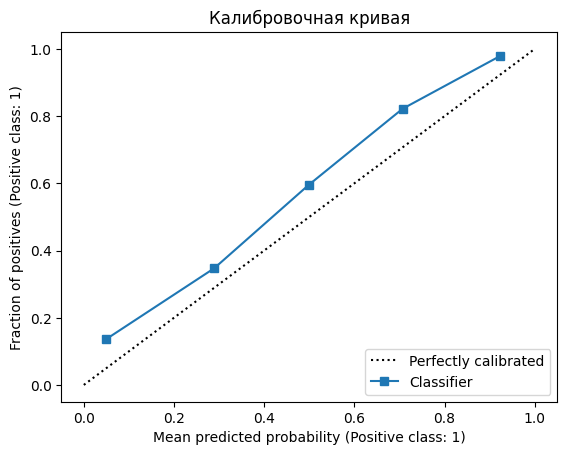

In [60]:
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

y_probs = lr.predict_proba(X_val)[:, 1]

disp = CalibrationDisplay.from_predictions(y_val, y_probs)

plt.title('Калибровочная кривая')
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?



```
Ответ: Потому что минимизируемая в логистической регрессии функция потерь позволяет естественно выдавать откалиброванные вероятности в диапазоне от 0 до 1.
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

In [61]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_probs_rf = rf.predict_proba(X_val)[:, 1]

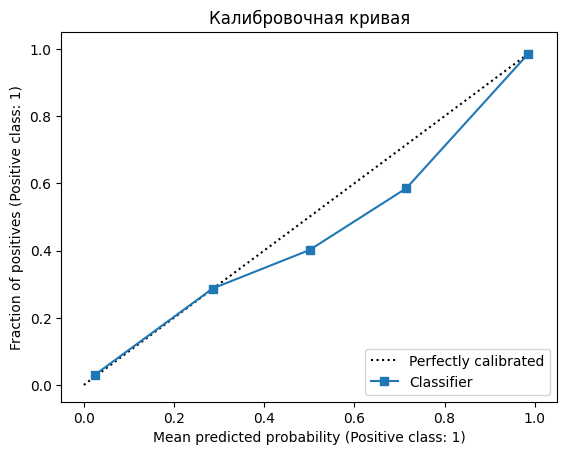

In [62]:
# Ваш код здесь (Logreg)

lr_calib = LogisticRegression()
lr_calib.fit(y_probs_rf.reshape(-1, 1), y_val)

y_pred_calib = lr_calib.predict_proba(y_probs_rf.reshape(-1, 1))[:, 1]

disp = CalibrationDisplay.from_predictions(y_val, y_pred_calib)

plt.title('Калибровочная кривая')
plt.show()

Такой график может говорить о том, что модель систематически занижает вероятности. Попробуем откалибровать методом изотонической регрессии.

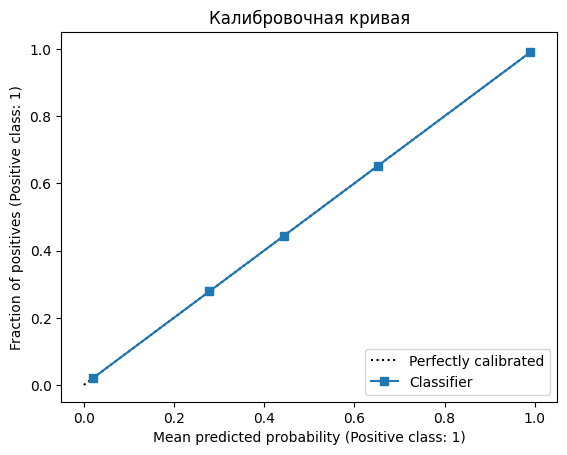

In [63]:
# Ваш код здесь (isoreg)

isoreg = IsotonicRegression(out_of_bounds='clip')
y_isoreg = isoreg.fit_transform(y_probs_rf, y_val)

disp = CalibrationDisplay.from_predictions(y_val, y_isoreg)

plt.title('Калибровочная кривая')
plt.show()

Калибровка по изотонической регрессии дала хороший результат, вероятности получились близкими к реальным. Благодаря более четкой настройке границ бинов.

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

**Наиболее широко используемые другие методы калибровки**
* Калибровка Платта представляет собой по сути применение сигмоиды поверх другой модели. Для избежания переобучения Платт предлагал также заменить метки на регуляризованные вероятности таргетов. Калибровка Платта неплохо справляется с выколачиванием вероятностей из SVM, но для более хитрых классификаторов может спасовать. В целом, можно показать, что этот метод хорошо работает, если для каждого из истинных классов предсказанные вероятности распределы нормально с одинаковыми дисперсиями. 

* Гистограммная калибровка Отрезок вероятностей разбивается на равноширотные и равномощные бины и на каждом предсказывается одна и та же вероятность (чтобы она лучше сближала средние метки классов на соответствующих бинах)


**Также применяются следущие методы**
* Matrix and Vector Scaling. Обобщение калибровки Платта

* Beta-калибровка

* Scaling-binning calibrator - сочетание биннинга и непараметрических методов

* Деревья калибровки

* Ансамблевые методы

* Temperature Scaling

* Maximum Mean Calibration Error (MMCE)

* Сглаживание меток (Label smoothing)

* Регуляризация с помощью энтропии 

* Использование фокальной ошибки (Focal Loss)

* DropOut и его обобщения


Источник:
https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti  
https://alexanderdyakonov.wordpress.com/2020/03/27/проблема-калибровки-уверенности/



### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

Для дерева решений получились значения bias, var: 0.0432, 0.0586

In [64]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [65]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    rf,
    X_train,
    y_train,
    X_val,
    y_val,
    loss='0-1_loss',
    num_rounds=20
)
print(f"bias: {bias_dt:.4f}, variance: {var_dt:.4f}")

bias: 0.0390, variance: 0.0088


У дерева и леса получился сопоставимый bias, хотя у леса он несколько ниже. Однако variance получился в 6,5 раз ниже. В целом это ожидаемый результат. Лес это ансамблеый метод, который обучается на основе множества выборок (бутстрэп) и значительно менее склонен к переобучению, чем отдельное решающее дерево.

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [66]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    lr,
    X_train,
    y_train,
    X_val,
    y_val,
    loss='0-1_loss',
    num_rounds=20
)
print(f"bias: {bias_dt:.4f}, variance: {var_dt:.4f}")

bias: 0.1526, variance: 0.0044


Логистическая регрессия показала значительно более высокий bias, чем случайный лес или решающее дерево. В целом это объяснимо природой моделей: дерево лучше справляется с моделированием сложных нелинейных зависимостей и способно показывать более высокую точность. При этом variance у логистической регрессии лучше, поскольку это обычная линейнам модель, менее склонна к переобучению.

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [67]:
from scipy.stats import randint, uniform

params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9)
}

rs = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=30, cv=4, random_state=42, n_jobs=6)
rs.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", rs.best_params_)

y_pred = rs.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Точность модели: ", accuracy)

Лучшие гиперпараметры:  {'max_depth': 17, 'max_features': 0.5722971942325502, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 104}
Точность модели:  0.961501411725627


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [68]:
# # замените X_train_enc на ваш трейн

# cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
# X_train_RF = X_train[cols_for_RF]
# # а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

# clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
# errors = []

# for n_estimators in range(1, 251, 5):
#     clf.set_params(n_estimators=n_estimators)
#     clf.fit(X_train_RF, y_train)

#     errors.append(1 - clf.oob_score_)

In [69]:
# plt.figure(figsize=(20, 14))
# plt.plot(range(1, 251, 5), errors)

# plt.xlabel('n_estimators')
# plt.ylabel('OOB score')
# plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


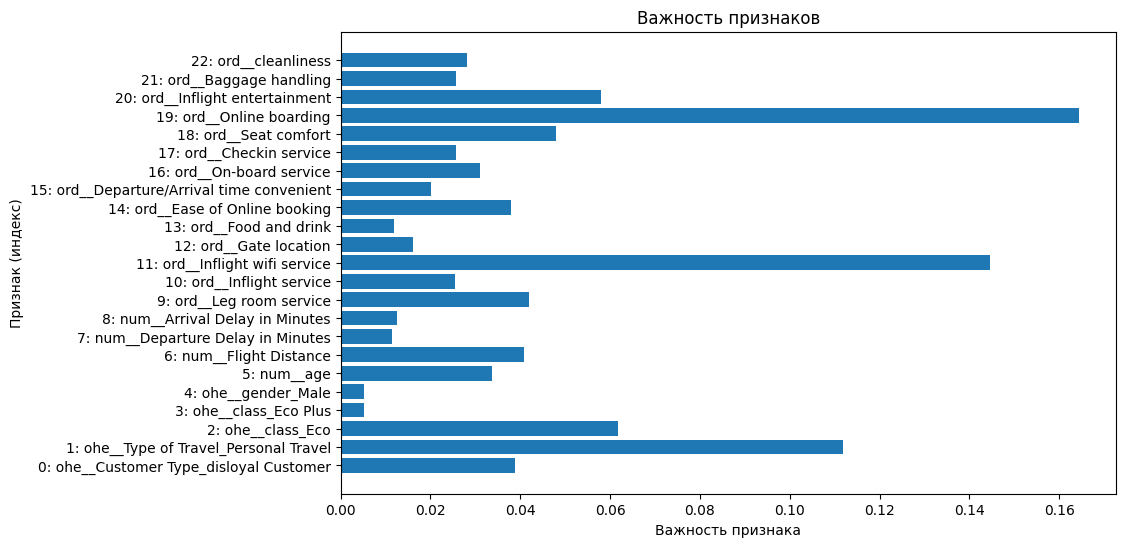

In [70]:
feature_importances = rf.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

indexed_feature_names = [f"{i}: {name}" for i, name in enumerate(feature_names)]

plt.figure(figsize=(10, 6))
plt.barh(indexed_feature_names, feature_importances, align='center')
plt.xlabel("Важность признака")
plt.ylabel("Признак (индекс)")
plt.title("Важность признаков")
plt.show()

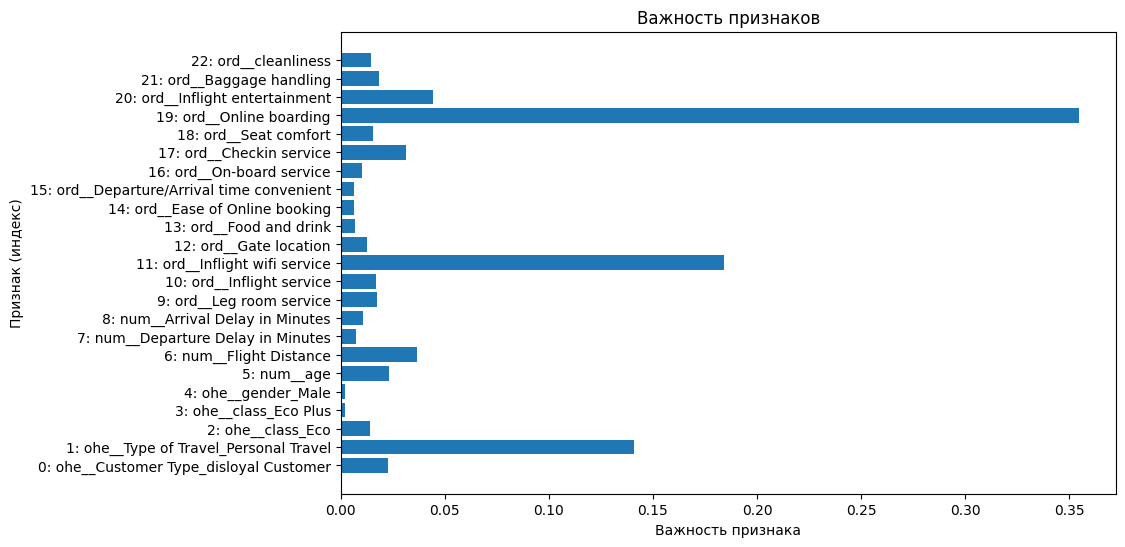

In [71]:
feature_importances = dt.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

indexed_feature_names = [f"{i}: {name}" for i, name in enumerate(feature_names)]

plt.figure(figsize=(10, 6))
plt.barh(indexed_feature_names, feature_importances, align='center')
plt.xlabel("Важность признака")
plt.ylabel("Признак (индекс)")
plt.title("Важность признаков")
plt.show()

C точки зрения важности признаков три наиболее важных признака совпадают для решающего дерева и случайного леса. По четвертому признаку происходит расхождение.

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [72]:
with open('best_rf.pkl', 'wb') as f:
    pickle.dump(rs.best_estimator_, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

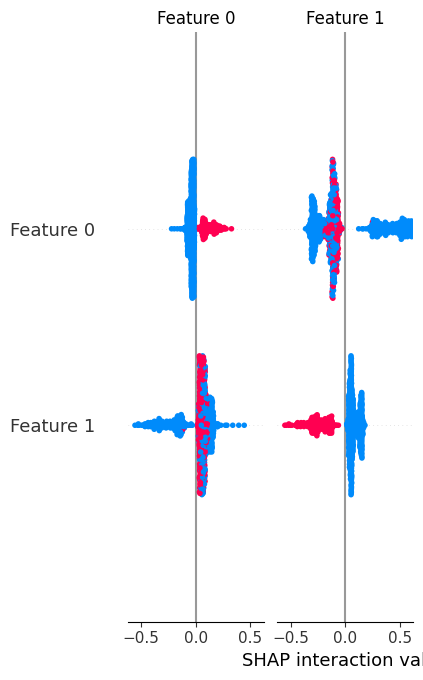

In [73]:
explainer = shap.TreeExplainer(rs.best_estimator_)

indices = np.random.choice(X_val.shape[0], 1000, replace=False)
X_sample = X_val[indices]

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample)

Метод Шепли вывел только два признака, что говорит о том, что остальные признаки не имеют высокой значимости. В целом это подтверждается ранее проведенным графическим анализом для случайного леса. Там также 2 признака по значимости существенно превышают остальные.

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

1. Библиотека работает как с деревьями так и с линейными моделями и нейронными сетями
2. Помимо графика shap_value есть график, показывающий вклад влияниях переменных на результирующий признак (shap.plots.force(shap_values[ind]))
3. Наглядный график Beeswarm (shap.plots.beeswarm), Violinplot: shap.summary_plot(plot_type="violin"), Barplot shap.plots.bar

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

In [74]:
from lime import lime_tabular

observation_index = 0
observation = X_val[observation_index]

explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=observation,
    predict_fn=model.predict_proba,
    num_features=len(X_train)
)

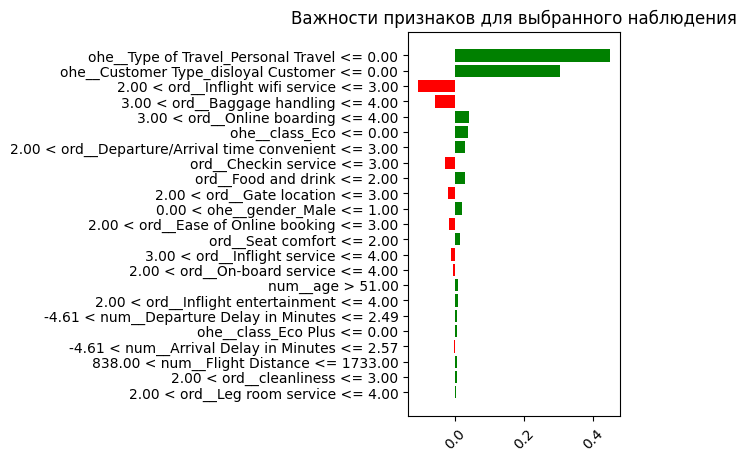

In [75]:
fig = exp.as_pyplot_figure()
plt.xticks(rotation=45)
plt.title('Важности признаков для выбранного наблюдения')
plt.tight_layout()
plt.show()

С наиболее высокой вероятностью неудовлетворенными останутся нелоявльные клиенты и пассажиры, отправляющиеся в частную поездку. При этом наличие wi-fi на борту снижает неудовлетворенность, а эконом-класс - повышает. 

Выводы коррелируют с результатами EDA.

## Котобонус!

0.25 балла

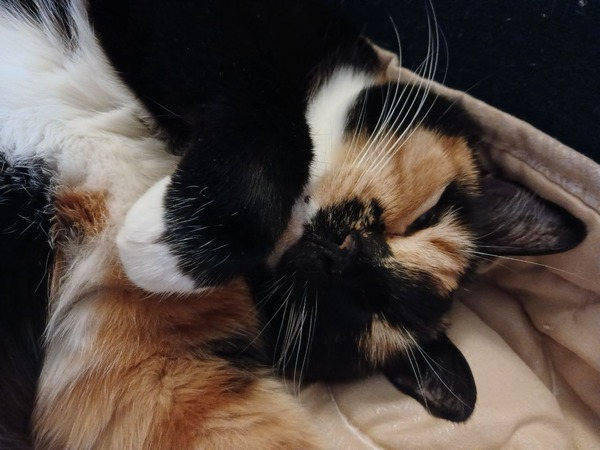

Не знаю, пусть Альбины

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

Было полезным повторить SQL-запросы и методы калибровки, а также задания по SHAP и LIME

**Предложения:**
1. В задании 6 надо обратить вниамние студента, что удаление выбросов из X_train и X_val должно сопровождаться синхронизацией y_train и y_val. Иначе далее будет мисмэтч между лейблами и семплом.
2. В задании 15 предложено вывести барплот с названиями признаков и уровнем важности. Но есть проблема: X_train является массимов Numpy, не содержащим название колонок, а использовать df_train.columns невозможно, поскольку после OHE столбцов X_train названия колонок df_train и их порядок в X_train не будут совпадать. Нужно предупредить в задании что имена можновзять из pipeline.

По сложности оцениваю на 6/10

Затраченное время 6 часов.